<h2 align="center">Codebasics DL Course: Vehicle Damage Detection Project</h2>

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load Data

In [2]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
dataset_path = "./dataset"

dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2300

In [33]:
2300*0.75

1725.0

In [4]:
class_names = dataset.classes
class_names 

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [5]:
num_classes = len(dataset.classes)
num_classes

6

In [6]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [7]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [9]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [10]:
labels[1]

tensor(0)

In [11]:
images[1].shape

torch.Size([3, 224, 224])

In [12]:
images[1].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0822659].


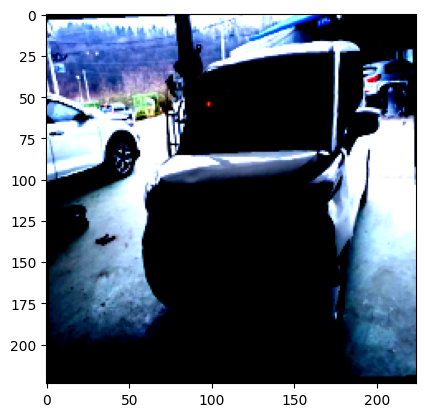

In [13]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

### Model 1: CNN

In [14]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [15]:
images.size(0)

32

In [16]:
len(train_loader.dataset)

1725

In [20]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [22]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=2)

Batch: 10, Epoch: 1, Loss: 1.80
Batch: 20, Epoch: 1, Loss: 1.66
Batch: 30, Epoch: 1, Loss: 1.52
Batch: 40, Epoch: 1, Loss: 1.46
Batch: 50, Epoch: 1, Loss: 1.34
Epoch [1/2], Avg Loss: 1.6545
*** Validation Accuracy: 48.35% ***
Batch: 10, Epoch: 2, Loss: 1.07
Batch: 20, Epoch: 2, Loss: 1.08
Batch: 30, Epoch: 2, Loss: 1.37
Batch: 40, Epoch: 2, Loss: 1.23
Batch: 50, Epoch: 2, Loss: 0.92
Epoch [2/2], Avg Loss: 1.2288
*** Validation Accuracy: 48.87% ***
Execution time: 169.99658632278442 seconds


### Model 2: CNN with Regularization

In [73]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [75]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=10)

Batch: 10, Epoch: 1, Loss: 14.10
Batch: 20, Epoch: 1, Loss: 4.84
Batch: 30, Epoch: 1, Loss: 1.41
Batch: 40, Epoch: 1, Loss: 1.50
Batch: 50, Epoch: 1, Loss: 1.93
Epoch [1/10], Avg Loss: 6.9776
*** Validation Accuracy: 39.48% ***
Batch: 10, Epoch: 2, Loss: 1.52
Batch: 20, Epoch: 2, Loss: 1.41
Batch: 30, Epoch: 2, Loss: 1.25
Batch: 40, Epoch: 2, Loss: 1.68
Batch: 50, Epoch: 2, Loss: 1.70
Epoch [2/10], Avg Loss: 1.4713
*** Validation Accuracy: 46.61% ***
Batch: 10, Epoch: 3, Loss: 1.21
Batch: 20, Epoch: 3, Loss: 1.22
Batch: 30, Epoch: 3, Loss: 1.37
Batch: 40, Epoch: 3, Loss: 1.32
Batch: 50, Epoch: 3, Loss: 1.28
Epoch [3/10], Avg Loss: 1.3041
*** Validation Accuracy: 50.09% ***
Batch: 10, Epoch: 4, Loss: 0.99
Batch: 20, Epoch: 4, Loss: 1.27
Batch: 30, Epoch: 4, Loss: 1.35
Batch: 40, Epoch: 4, Loss: 1.28
Batch: 50, Epoch: 4, Loss: 1.12
Epoch [4/10], Avg Loss: 1.2812
*** Validation Accuracy: 48.00% ***
Batch: 10, Epoch: 5, Loss: 1.16
Batch: 20, Epoch: 5, Loss: 1.24
Batch: 30, Epoch: 5, Loss: 

### Model 3: Transfer Learning with EfficientNet

In [23]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\pruth/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:01<00:00, 20.2MB/s]


1280

In [24]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x              

In [81]:
model = CarClassifierEfficientNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.69
Batch: 20, Epoch: 1, Loss: 1.55
Batch: 30, Epoch: 1, Loss: 1.47
Batch: 40, Epoch: 1, Loss: 1.30
Batch: 50, Epoch: 1, Loss: 1.23
Epoch [1/10], Avg Loss: 1.5018
*** Validation Accuracy: 52.70% ***
Batch: 10, Epoch: 2, Loss: 1.26
Batch: 20, Epoch: 2, Loss: 0.99
Batch: 30, Epoch: 2, Loss: 1.11
Batch: 40, Epoch: 2, Loss: 1.06
Batch: 50, Epoch: 2, Loss: 1.05
Epoch [2/10], Avg Loss: 1.1384
*** Validation Accuracy: 60.52% ***
Batch: 10, Epoch: 3, Loss: 0.86
Batch: 20, Epoch: 3, Loss: 1.01
Batch: 30, Epoch: 3, Loss: 0.94
Batch: 40, Epoch: 3, Loss: 1.00
Batch: 50, Epoch: 3, Loss: 1.13
Epoch [3/10], Avg Loss: 1.0067
*** Validation Accuracy: 62.78% ***
Batch: 10, Epoch: 4, Loss: 1.12
Batch: 20, Epoch: 4, Loss: 0.88
Batch: 30, Epoch: 4, Loss: 0.99
Batch: 40, Epoch: 4, Loss: 1.14
Batch: 50, Epoch: 4, Loss: 1.12
Epoch [4/10], Avg Loss: 0.9476
*** Validation Accuracy: 63.65% ***
Batch: 10, Epoch: 5, Loss: 0.90
Batch: 20, Epoch: 5, Loss: 0.92
Batch: 30, Epoch: 5, Loss: 0

### Model 4: Transfer Learning with ResNet

In [82]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [80]:
model = CarClassifierResNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.18
Batch: 20, Epoch: 1, Loss: 0.54
Batch: 30, Epoch: 1, Loss: 0.65
Batch: 40, Epoch: 1, Loss: 0.81
Batch: 50, Epoch: 1, Loss: 0.77
Epoch [1/10], Avg Loss: 0.8738
*** Validation Accuracy: 71.65% ***
Batch: 10, Epoch: 2, Loss: 0.35
Batch: 20, Epoch: 2, Loss: 0.43
Batch: 30, Epoch: 2, Loss: 0.47
Batch: 40, Epoch: 2, Loss: 0.50
Batch: 50, Epoch: 2, Loss: 0.43
Epoch [2/10], Avg Loss: 0.4777
*** Validation Accuracy: 78.78% ***
Batch: 10, Epoch: 3, Loss: 0.29
Batch: 20, Epoch: 3, Loss: 0.24
Batch: 30, Epoch: 3, Loss: 0.39
Batch: 40, Epoch: 3, Loss: 0.27
Batch: 50, Epoch: 3, Loss: 0.24
Epoch [3/10], Avg Loss: 0.3236
*** Validation Accuracy: 77.57% ***
Batch: 10, Epoch: 4, Loss: 0.20
Batch: 20, Epoch: 4, Loss: 0.16
Batch: 30, Epoch: 4, Loss: 0.30
Batch: 40, Epoch: 4, Loss: 0.17
Batch: 50, Epoch: 4, Loss: 0.60
Epoch [4/10], Avg Loss: 0.2373
*** Validation Accuracy: 80.52% ***
Batch: 10, Epoch: 5, Loss: 0.19
Batch: 20, Epoch: 5, Loss: 0.11
Batch: 30, Epoch: 5, Loss: 0

#### I ran hyperparameter tunning in another notebook and figured that the best parameters for resnet models are (1) Dropout rate = 0.2 (2) Learning Rate = 0.005

So now let's train the model once again with these best parameters

In [83]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=3)

Batch: 10, Epoch: 1, Loss: 1.56
Batch: 20, Epoch: 1, Loss: 0.99
Batch: 30, Epoch: 1, Loss: 0.88
Batch: 40, Epoch: 1, Loss: 0.48
Batch: 50, Epoch: 1, Loss: 0.76
Epoch [1/10], Avg Loss: 1.0021
*** Validation Accuracy: 71.65% ***
Batch: 10, Epoch: 2, Loss: 0.43
Batch: 20, Epoch: 2, Loss: 0.47
Batch: 30, Epoch: 2, Loss: 0.58
Batch: 40, Epoch: 2, Loss: 0.60
Batch: 50, Epoch: 2, Loss: 0.48
Epoch [2/10], Avg Loss: 0.5265
*** Validation Accuracy: 73.04% ***
Batch: 10, Epoch: 3, Loss: 0.38
Batch: 20, Epoch: 3, Loss: 0.23
Batch: 30, Epoch: 3, Loss: 0.23
Batch: 40, Epoch: 3, Loss: 0.26
Batch: 50, Epoch: 3, Loss: 0.30
Epoch [3/10], Avg Loss: 0.3634
*** Validation Accuracy: 80.87% ***
Batch: 10, Epoch: 4, Loss: 0.36
Batch: 20, Epoch: 4, Loss: 0.17
Batch: 30, Epoch: 4, Loss: 0.31
Batch: 40, Epoch: 4, Loss: 0.34
Batch: 50, Epoch: 4, Loss: 0.24
Epoch [4/10], Avg Loss: 0.2801
*** Validation Accuracy: 78.43% ***
Batch: 10, Epoch: 5, Loss: 0.23
Batch: 20, Epoch: 5, Loss: 0.07
Batch: 30, Epoch: 5, Loss: 0

### Model Evaluation using Confusion Matrix and Classification Report

In [87]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.93      0.82       119
           1       0.82      0.69      0.75        98
           2       0.96      0.81      0.88       122
           3       0.84      0.65      0.74        81
           4       0.70      0.71      0.71        80
           5       0.75      0.92      0.83        75

    accuracy                           0.79       575
   macro avg       0.80      0.79      0.79       575
weighted avg       0.81      0.79      0.79       575



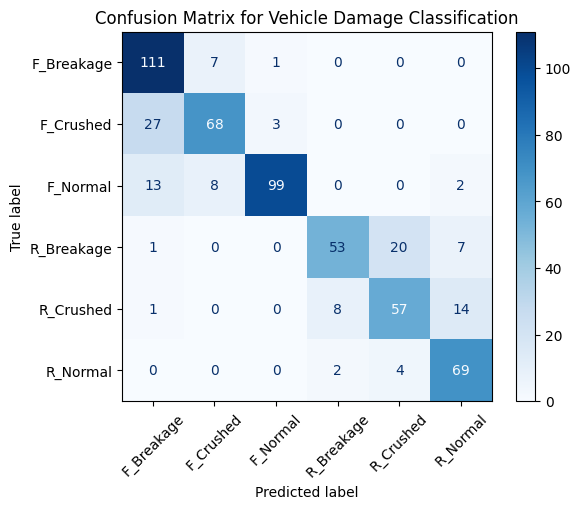

In [90]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

### Save the Model

In [91]:
torch.save(model.state_dict(), 'saved_model.pth')